# Анализ метрик мобильного приложения игры

## 0. Поставновка задач

1. Рассчитаем retention игроков (по дням от даты регистрации игрока) на основании данных о регистрации и активности пользователей в игре.
2. На основе имеющихся результатов A/B теста наборов акционных предложений определим лучший набор.
3. Подберем релевантные метрики для оценки результатов последнего прошедшего тематического события в игре.

## 1. Расчет retention

### Исходные данные

Данные лежат в папке shared и имеют следующую структуру:

* data/problem1-reg_data.csv – данные о времени регистрации (формат timestamp) 

| reg_ts    | uid |
|:---------:|:---:|
| 906166566 | 2   |
| 906344325	| 3   |
| 906686169	| 4   |
| 906893386	| 5   |
| 906980227	| 6   |


* data/problem1-auth_data.csv – данные о времени захода пользователей в игру (формат timestamp)

| auth_ts	| uid |
|:---------:|:---:|
| 906166566	| 2   |
| 924422172	| 2   |
| 937374732	| 2   |
| 947425117	| 2   |
| 955630339	| 2   |


### Решение

#### 1. Загруза данных

In [54]:
# Импорт библиотек
import datetime
import os

import numpy as np
import pandas as pd
import requests
import seaborn as sns
from scipy.stats import chi2_contingency, levene
from statsmodels.stats.proportion import proportions_ztest

import pingouin as pg
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

In [55]:
reg_data = pd.read_csv("~/data/problem1-reg_data.csv", sep=";")
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [56]:
auth_data = pd.read_csv("~/data/problem1-auth_data.csv", sep=";")
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


#### 2. Исследовательский анализ данных (EDA) и подготовка данных

Выведем структуру датафреймов reg_data и auth_data:

In [57]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [58]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


Преобразуем timestamp в datetime для полей reg_ts и auth_ts:

In [59]:
reg_data.reg_ts = reg_data.reg_ts.apply(datetime.datetime.utcfromtimestamp)
auth_data.auth_ts = auth_data.auth_ts.apply(datetime.datetime.utcfromtimestamp)

Проверим uid в датафрейме reg_ts на уникальность

In [60]:
reg_data.uid.nunique() == len(reg_data.uid)

True

Объединим данные в единый датафрейм по полю uid

In [61]:
df = reg_data.merge(auth_data, how='inner',on='uid').iloc[:,[1,0,2]]

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9601013 entries, 0 to 9601012
Data columns (total 3 columns):
 #   Column   Dtype         
---  ------   -----         
 0   uid      int64         
 1   reg_ts   datetime64[ns]
 2   auth_ts  datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 293.0 MB


Преобразуем datetime в date:

In [94]:
df['reg_ts'] = pd.to_datetime(df['reg_ts'].dt.date)
df['auth_ts'] = pd.to_datetime(df['auth_ts'].dt.date)
df.head()

,uid,reg_ts,auth_ts
0,1,1998-11-18,1998-11-18
1,2,1999-07-22,1999-07-22
2,2,1999-07-22,1999-07-25
3,2,1999-07-22,1999-07-31
4,2,1999-07-22,1999-08-05


#### 3. Функция для расчета Retention

Напишем функцию для расчета Retention:

In [64]:
def get_retention(data, start_date, end_date):
    # Приводим параметры к типу datetime
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Определяем минимальную и максимальную дату в датафрейме по колонке 'reg_ts' и 'auth_ts'
    min_date = min(data['reg_ts'].min(), data['auth_ts'].min())
    max_date = max(data['reg_ts'].max(), data['auth_ts'].max())
    
    # Корректируем start_date и end_date, чтобы они были в пределах доступных дат
    start_date, end_date = sorted([start_date, end_date])
    start_date = max(start_date, min_date)
    end_date = min(end_date, max_date)
    
    # Фильтрация по датам регистрации и аутентификации
    filtered = data.loc[(data['reg_ts'] >= start_date) & (data['auth_ts'] <= end_date)].copy()
    
    if filtered.empty:
        # Если после фильтрации нет данных, возвращаем пустые DataFrame и Series
        print("Данные для расчета Retention не найдены. Проверьте start_date и end_date")
        return pd.DataFrame(), pd.Series(dtype=int)
    
    # Вычисление количества дней между регистрацией и аутентификацией
    filtered['days_since_reg'] = (filtered['auth_ts'] - filtered['reg_ts']).dt.days
    filtered['reg_date_str'] = filtered['reg_ts'].dt.strftime('%Y-%m-%d')
    
    # Группировка по дате регистрации и количеству дней, подсчёт уникальных пользователей
    grouped = filtered.groupby(['reg_date_str', 'days_since_reg']) \
        .agg(user_count=('uid', 'nunique')) \
        .reset_index()
    
    # Преобразование в матрицу retention
    matrix = grouped.pivot(index='reg_date_str', columns='days_since_reg', values='user_count')
    
    if 0 not in matrix.columns:
        # Если нет столбца с days_since_reg == 0, вернуть пустые результаты или обработать иначе
        return pd.DataFrame(), pd.Series(dtype=int)
    
    cohorts = matrix[0]
    matrix = np.round(matrix.div(cohorts, axis=0), 3)
    dimension = len(matrix)
    
    print(f"Retention рассчитан. Возвращена матрица {dimension} x {dimension}")
    return matrix, cohorts

Зададим граничные даты для запуска функции на части датасета (семпле). И протестируем работу функции.

In [65]:
start_date = "2020-07-22"
end_date = "2020-08-22"

retention_matrix, cohorts = get_retention(df, start_date, end_date)

Retention рассчитан. Возвращена матрица 32 x 32


Построим тепловую карту на основе результатов работы функции:

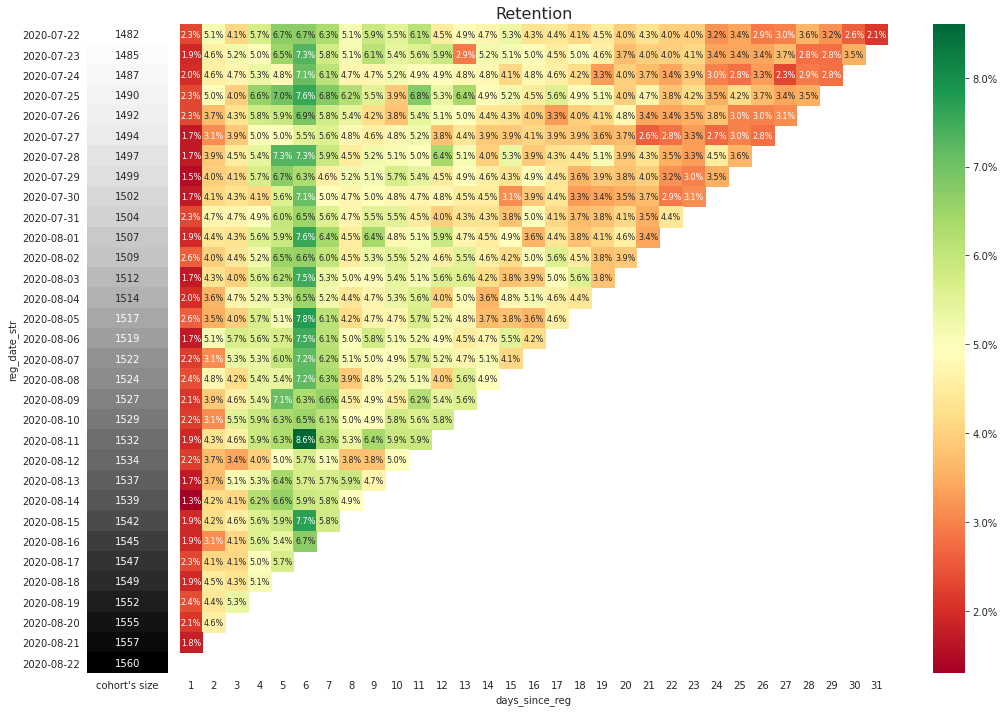

In [66]:
#Уберём первый столбец из матрицы retention для более выраженной разницы в цветах ячеек
hmap_matrix = retention_matrix.iloc[:,1:]

# Построим тепловую карту из матрицы retention
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(15, 10), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Тепловая карта для retention
    sns.heatmap(hmap_matrix,
                mask=hmap_matrix.isnull(),
                annot=True,
                annot_kws={"size": 8},
                fmt='.1%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Retention', fontsize=16)
    ax[1].set(ylabel='')
    
    # Шкалу также укажем в процентах
    cbar = ax[1].collections[0].colorbar
    cbar.ax.set_yticklabels([f"{x:.1%}" for x in cbar.get_ticks()])

    # Тепловая карта для размеров когорт
    cohort_sizes = pd.DataFrame(cohorts).rename(columns={0: "cohort's size"})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_sizes,
                annot=True,
                cbar=False,
                fmt='g',
                cmap= 'Greys',
                ax=ax[0])
  
    
    fig.tight_layout()
    plt.show()

## 2. Сравнение акционных предложений

### Контекст и цель

Проведён A/B‑тест: двум случайным группам пользователей предлагались разные наборы акционных предложений. Из исходных данных известно:
- Контрольная группа (A): 202103 пользователей, платящих — 1928.
- Тестовая группа (B): 202667 пользователей, платящих — 1805.
- При этом наблюдается, что ARPU в тестовой группе выше примерно на 5%.

Цель анализа — принять решение, можно ли считать набор предложений в тестовой группе предпочтительным с точки зрения дохода и бизнес-модели, и какие дополнительные метрики и проверки нужны для уверенного решения.


Данные по пользователям и группам выглядят следующим образом:

| user_id    | revenue | testgroup |
|:----------:|:-------:|:---------:|
| 1 | 0 | b |
| 2	| 0	| a |
| 3	| 0	| a |
| 4	| 0	| b |
| 5	| 0	| b |


 

### Решение

#### 1. Метрики для выбора лучшего набора предложений

Для определения лучшего из двух наборов акционных предложений помогут следующие метрики:

1. **Конверсия в платящего (CR)** — доля платящих игроков. Показывает насколько хорошо предложения мотивируют игроков стать платящими.
2. **ARPPU** — средняя выручка на платящего игрока. Показывает сколько в среднем тратят платящие игроки.
3. **ARPU** — средняя выручка на игрока. Совокупный показатель, учитывающий и конверсию и средний чек платящих.
4. **Retention** — доля игроков, продолжающих пользоваться продуктом компании по истечению времени.

Здесь CR и ARPPU — это proxy-метрики. Метрика ARPU — основная. Метрика Retention — guardrail. К сожалению, информация для расчета Retention недостаточно, следовательно эту метрику анализировать не будем.

#### 2. Загрузка исходных данных

In [67]:
# Публичная ссылка на CSV-файл с исходными данными (Яндекс-диск):
link = "https://disk.yandex.ru/d/SOkIsD5A8xlI7Q",

# Адрес endpoint Yandex API для получения прямых ссылок на скачивание
API_URL = "https://cloud-api.yandex.net/v1/disk/public/resources/download"

# Получение прямой ссылки на файл посредством API-запроса
resp = requests.get(API_URL, params={"public_key": link})
resp.raise_for_status()                   # Проверка на случай ошибки запроса
download_url = resp.json()["href"]

# Загрузка данных из CSV-файла в соответствующий датафрейм
ab = pd.read_csv(download_url, sep=';')

ab.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


#### 3. Исследовательский анализ данных (EDA)

Структура датафрейма:

In [68]:
ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB



Описательные статистики выручки:

In [69]:
ab['revenue'].describe()

count    404770.000000
mean         26.083435
std         681.652928
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

Описательные статистики групп:

In [70]:
ab[['testgroup']].describe()

,testgroup
count,404770
unique,2
top,b
freq,202667


Как было отмечено выше, **группа A - контрольная** (202103 игрока), **группа B - тестовая** (202667 игроков)

Проверим датасет на дубли в user_id - независимость пользователей внутри групп и между группами:

In [71]:
ab.user_id.nunique()

404770

Все user_id в датасете уникальны, следовательно условие независимости выполняется. Количество игроков в обеих группах примерно одинаковое: 202103 и 202667 (разница 0.28%), что похоже на случайное распределение пользователей по группам.

Ввиду отсутствия дополнительных данных для анализа пользователей в группах A и B, будем предпологать, что система сплитования при проведении A/B-теста сработала корректно.

Исследуем характер распределения выручки в каждой группе.

In [72]:
# Разделим исходный датафрейм на 2 группы
a = ab[ab['testgroup']=="a"]
b = ab[ab['testgroup']=="b"]

# Создадим датафреймы только с платящими пользователями
ap = a[a['revenue']>0]
bp = b[b['revenue']>0]

Выведем описательные статистики для выручки в группах A и B для всех пользователей:

In [73]:
a['revenue'].describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [74]:
b['revenue'].describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

Выручка по всем платящим игрокам является выбросами в группах A и B, содержащих всех игроков (датафреймы **a** и **b**), т.к. межквартильные расстояния в этих группах равны нулю.

Определим статистическую значимость различий в дисперсиях между группами:  
(H0 - дисперсии в обеих группах равны)

In [75]:
stat, p_value = levene(a['revenue'], b['revenue'])
if p_value < 0.05:
    print(f"Отвергаем H0: дисперсии в группах статистически значимо различаются.")
    print(f" P_value = {p_value:0.4f} < 0.05.")
else:
    print(f"Нет оснований отвергать H0: статистически значимых различий в дисперсиях нет.")
    print(f"P_value = {p_value:0.4f} >= 0.05.")    

Нет оснований отвергать H0: статистически значимых различий в дисперсиях нет.
P_value = 0.5325 >= 0.05.


Выведем описательные статистики для выручки в группах A и B только для платящих игроков:

In [76]:
ap['revenue'].describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64


Контрольная группа A из платящих игроков (датафрейм **ap**) также имеет выбросы, поскольку содержит значения выручки, превышающие 361 + 1.5*IQR = 517 при межквартильном расстоянии IQR = 361-257 = 104.

In [77]:
bp['revenue'].describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

Тестовая группа B из платящих игроков (датафрейм **bp**) не имеет выбросов, поскольку не содержит значения выручки, превышающие 3478 + 1.5*IQR = 4926 при межквартильном расстоянии IQR = 3478-2513 = 965.

Определим статистическую значимость различий в дисперсиях между группами платящих пользователей:  
(H0 - дисперсии в обеих группах равны)

In [78]:
stat, p_value = levene(ap['revenue'], bp['revenue'])
if p_value < 0.05:
    print(f"Отвергаем H0: дисперсии в группах статистически значимо различаются.")
    print(f" P_value = {p_value:0.4f} < 0.05.")
else:
    print(f"Нет оснований отвергать H0: статистически значимых различий в дисперсиях нет.")
    print(f"P_value = {p_value:0.4f} >= 0.05.")    

Отвергаем H0: дисперсии в группах статистически значимо различаются.
 P_value = 0.0000 < 0.05.


Приведенные выше выводы о наличии выбросов подтверждаются визуализацией данных в виде "ящиков с усами":

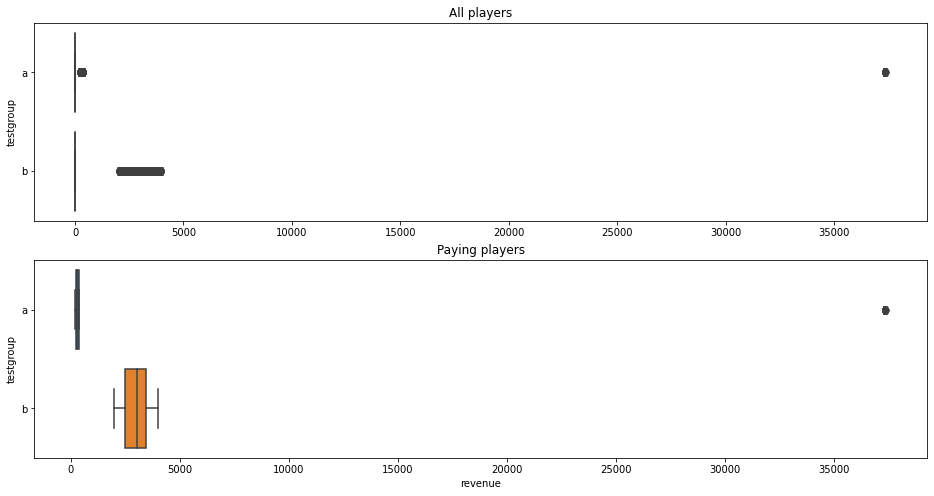

In [79]:
data = ab.sort_values(by='testgroup')
fig, axs = plt.subplots(2, 1, figsize=(16, 8))
sns.boxplot(x=data['revenue'], y=data['testgroup'], ax=axs[0])
sns.boxplot(x=data[data['revenue']>0]['revenue'], y=data['testgroup'], ax=axs[1])
axs[0].set_xlabel('')
axs[0].set_title('All players')
axs[1].set_xlabel('revenue')
axs[1].set_title('Paying players')
plt.show()

Для большей наглядности, визуализируем указанные выше распределения на гистограмме c логарифмированием по обеим осям:

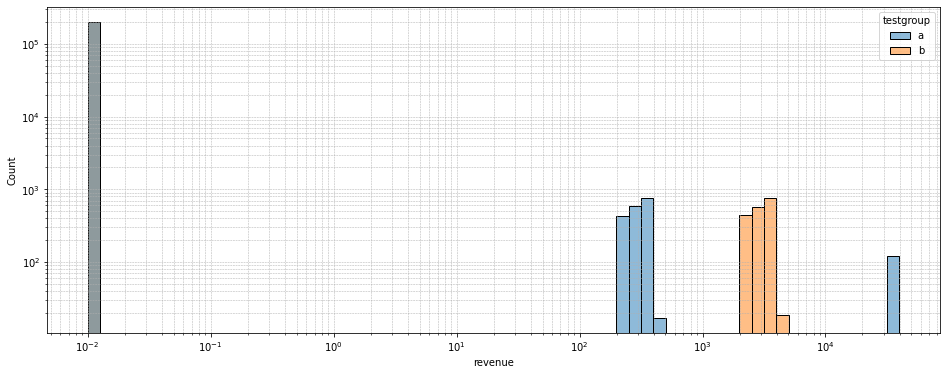

In [80]:
fig, ax = plt.subplots(1,1, figsize=(16, 6))
data.revenue = ab.revenue.apply(lambda x: x + 0.01) # Прибавляем 0.01 к выручке, чтобы можно было взять логарифм
sns.histplot(data= data, x=data.revenue, hue=data.testgroup, log_scale=(True,True),bin=0.1)
plt.grid(True, which='both', ls='--', linewidth=0.5)

Здесь количество платящих игроков обех групп примерно равно. Они изображены слева на гистограмме серым цветом с выручкой ~0 (10^-2). Платящие игроки группы A показаны голубым с выручкой от ~200 до ~500 и выбросом с выручкой от ~30k до ~40k.  
Платящие игроки группы B показаны оранжевым цветом с выручкой от ~2k до ~5k .

Выводы:
- Выборки как по всем пользователям так и только по платящим содержат выбросы.
- Для платящих пользователей дисперсия в группах A и B статистически значимо различается, для всех пользователей - нет.

#### 4. Расчет метрик

Рассчитаем метрики **CR**, **ARPU** и **ARPPU** для групп A и B:

In [81]:
cr_a = len(ap) / len(a) * 100
cr_b = len(bp) / len(b) * 100
print(f"CR в группе A: {cr_a:.2f}%")
print(f"CR в группе B: {cr_b:.2f}%")
print(f"Различие в метрике: {(cr_b/cr_a-1)*100:.2f}%")

CR в группе A: 0.95%
CR в группе B: 0.89%
Различие в метрике: -6.64%


In [82]:
arpu_a = a.revenue.sum() / len(a)
arpu_b = b.revenue.sum() / len(b)
print(f"ARPU в группе A: {arpu_a:.2f}")
print(f"ARPU в группе B: {arpu_b:.2f}")
print(f"Различие в метрике: {(arpu_b/arpu_a-1)*100:.2f}%")

ARPU в группе A: 25.41
ARPU в группе B: 26.75
Различие в метрике: 5.26%


In [83]:
arppu_a = a.revenue.sum() / len(ap)
arppu_b = b.revenue.sum() / len(bp)
print(f"ARPPU в группе A: {arppu_a:.2f}")
print(f"ARPPU в группе B: {arppu_b:.2f}")
print(f"Различие в метрике: {(arppu_b/arppu_a-1)*100:.2f}%")

ARPPU в группе A: 2664.00
ARPPU в группе B: 3003.66
Различие в метрике: 12.75%


Итого, в тестовой группе B по сравнению с контрольной A конверсия CR упала примерно на 7%, ARPU выросла на 5%, а ARPPU выросла на 13%.

#### 5. Анализ выбросов

Отфильтруем игроков группы А с размером выручки 30000 и выше:

In [84]:
ap[ap.revenue >= 30000]

,user_id,revenue,testgroup
416,417,37324,a
4428,4429,37304,a
5777,5778,37315,a
8065,8066,37307,a
8743,8744,37334,a
...,...,...,...
360696,360697,37347,a
378668,378669,37297,a
389341,389342,37298,a
394580,394581,37302,a


Здесь незаметно каких-либо ошибок или опечаток в данных.

Построим распределение выручки для таких игроков:

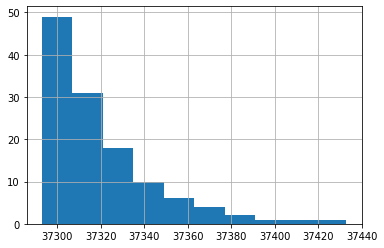

In [85]:
ap.revenue[ap.revenue >= 30000].hist()

Распределение также не выглядит необычным.

Если из группы А удалить выбросы с выручкой 30000 и выше, то получим:

In [86]:
сr_a = len(ap[ap.revenue < 30000]) / len(a[a.revenue < 30000]) * 100
cr_b = len(bp) / len(b) * 100
print(f"CR в группе A (выручка < 30000): {cr_a:.2f}%")
print(f"CR в группе B: {cr_b:.2f}%")
print(f"Различие в метрике: {(cr_b/cr_a-1)*100:.2f}%")

CR в группе A (выручка < 30000): 0.95%
CR в группе B: 0.89%
Различие в метрике: -6.64%


In [87]:
arpu_a = a[a.revenue < 30000].revenue.sum() / len(a[a.revenue < 30000])
arpu_b = b.revenue.sum() / len(b)
print(f"ARPU в группе A (выручка < 30000): {arpu_a:.2f}")
print(f"ARPU в группе B: {arpu_b:.2f}")
print(f"Различие в метрике: {(arpu_b/arpu_a-1)*100:.2f}%")

ARPU в группе A (выручка < 30000): 2.70
ARPU в группе B: 26.75
Различие в метрике: 889.72%


In [88]:
arppu_a = a[a.revenue < 30000].revenue.sum() / len(ap[ap.revenue < 30000])
arppu_b = b.revenue.sum() / len(bp)
print(f"ARPPU в группе A (выручка < 30000): {arppu_a:.2f}")
print(f"ARPPU в группе B: {arppu_b:.2f}")
print(f"Различие в метрике: {(arppu_b/arppu_a-1)*100:.2f}%")

ARPPU в группе A (выручка < 30000): 302.46
ARPPU в группе B: 3003.66
Различие в метрике: 893.08%


**Итого:** Выбросы сильно влияют на метрики ARPU и ARPPU и не похожи на следствие опечаток/ошибок в данных, поэтому удалять их нельзя.

#### 6. Оценка статистической значимости различий метрик между группами

Возможные тесты статзначимости различия метрик:
1. **CR**: **Хи-квадрат** (подходит для анализа конверсий и подобных им метрик, когда пользователь совершил или не совершил определённое действие) или **z-тест для пропорций**.
2. **ARPU, ARPPU**: **t-тест**, **bootstrapping** или **U-тест** (непараметрический тест Манна-Уитни).


#### 7. Статзначимость различий в конверсиях CR

Оценим статистическую значимость различий в конверсиях.  
H0: CR в группах не различается

Метод Хи-квадрат:

In [89]:
# Исходные данные
n_A = len(a)               # всего пользователей в группе A
paid_A = len(ap)           # платящих в группе A
not_paid_A = n_A - paid_A  # неплатящих в группе A

n_B = len(b)               # всего пользователей в группе B
paid_B = len(bp)           # платящих в группе B
not_paid_B = n_B - paid_B  # неплатящих в группе B

# Формируем таблицу сопряжённости 2x2
contingency_table = np.array([
    [paid_A, not_paid_A],
    [paid_B, not_paid_B]
])

# Применяем хи-квадрат тест
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi2 статистика: {chi2:.4f}")
print(f"P-value: {p_value:.4e} (порог значимости: 0.05)")
print(f"Степени свободы: {dof}")

# Интерпретация
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: конверсии в группах статистически значимо различаются.")
else:
    print("Нет оснований отвергать нулевую гипотезу: статистически значимых различий в конверсиях нет.")

Chi2 статистика: 4.3747
P-value: 3.6476e-02 (порог значимости: 0.05)
Степени свободы: 1
Отвергаем нулевую гипотезу: конверсии в группах статистически значимо различаются.


z-тест для пропорций:

In [90]:
count = np.array([paid_A, paid_B]) # число успехов (платящих) в группах A и B
nobs = np.array([n_A, n_B])        # размеры выборок

stat, p_value = proportions_ztest(count, nobs)

print(f"z-статистика: {stat:.4f}")
print(f"P-value: {p_value:.4e}")

alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: конверсии в группах статистически значимо различаются.")
else:
    print("Нет оснований отвергать нулевую гипотезу.")

z-статистика: 2.1080
P-value: 3.5029e-02
Отвергаем нулевую гипотезу: конверсии в группах статистически значимо различаются.


#### 8. Статзначимость различий в ARPU и ARPPU

Оценим статистическую значимость различий в ARPU и ARPPU. 

Соответствующие нулевые гипотезы:  
- H0: ARPU в группах не различается.  
- H0p: ARPPU в группах не различается.  

Для того, чтобы можно было использовать t-тест, должны соблюдаться условия:

|# |Условие|Соблюдено для ARPU| Соблюдено для ARPPU|
|:-|:------|:-------:|:-------:|
|1 |Данные количественные и независимые | Да | Да |
|2 |Выборки больше 30 элементов или данные примерно нормальны | Да | Да |
|3 |Дисперсии в группах не различаются статистически значимо  | Да | Нет |
|4 |Нет сильных выбросов или они обработаны | Нет | Нет |
|5 |Цель — сравнить средние значения между двумя группами | Да | Да |

Поскольку удалить выбросы из данных в нашем случае нельзя, придётся использовать другой критерий вместо t-теста.

Воспользуемся bootstrapping:

In [91]:
# Функция для расчета разницы средних значений двух выборок x и y
def diff(x, y):
    return y.mean() - x.mean()

In [92]:
# Определение доверительного интервала для разницы ARPU групп A и B методом bootstrap
arpu_ci = pg.compute_bootci(a.revenue, b.revenue, func=diff, method='percentile', \
    confidence=0.95, n_boot=1000, seed=42)  # Для быстроты вычислений число сэмплов берем по минимуму - 1000

print(f"95% доверительный интервал для разницы ARPU: {arpu_ci}")

95% доверительный интервал для разницы ARPU: [-2.94  5.58]


Поскольку доверительный интервал пересекает ноль, то различия в среднем значении ARPU статистически **незначимы**.

In [93]:
# Определение доверительного интервала для разницы ARPPU групп A и B методом bootstrap
arppu_ci = pg.compute_bootci(ap.revenue, bp.revenue, func=diff, method='percentile', \
    confidence=0.95, n_boot=1000, seed=42)  # Для быстроты вычислений число сэмплов берем по минимуму - 1000

print(f"95% доверительный интервал для разницы ARPU: {arppu_ci}")

95% доверительный интервал для разницы ARPU: [-181.08  674.33]


Поскольку доверительный интервал пересекает ноль, то различия в среднем значении ARPPU статистически **незначимы**.

#### 9. Выводы

1. Тестовый набор акционных предложений ухудшает конверсию — уменьшается общее число платящих игроков.
2. Рост ARPU и ARPPU не подтверждён статистически — нельзя с уверенностью сказать, что платящие стали тратить больше.
3. Общий эффект на доход (ARPU) не доказан — несмотря на полученные +5%, статистически значимого роста дохода нет.

#### 10. Результат (принятое решение)

1. Отказываемся от тестового набора предложений, так как он снижает конверсию, а рост дохода не подтверждён.
2. Для улучшения ARPU/ARPPU будем искать другие варианты предложений, не ухудшающих конверсию.
3. Добавим мониторинг и анализ других (guardrail) метрик (Retention, LTV), чтобы понять долгосрочные эффекты.

## 3. Метрики для оценки тематического события в игре

### Контекст и цель

В игре каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. Требуется предложить набор метрик для оценки результатов последнего прошедшего события

Дополнительный сценарий: усложнение механики событий таким образом, что при каждой неудачной попытке выполнения уровня игрок теперь откатывается на несколько уровней назад.  Требуется предложить набор метрик для усложненной механики.

### Решение

#### 1. Метрики для оценки результатов последнего прошедшего события

Для оценки успешности и вовлечённости игроков в тематическом событии можно использовать следующие метрики:

1. Метрики вовлечённости и активности
  
    - Процент участников события — доля игроков, которые начали участвовать в событии от общего числа активных игроков.
    - Среднее количество пройденных уровней в событии — насколько глубоко игроки проходили событие.
    - Среднее время, затраченное на прохождение события — помогает понять, насколько событие было интересным и/или сложным.
    - Количество попыток на уровень — среднее число попыток, которые игроки делают для прохождения уровней.
    - Retention внутри события — сколько игроков возвращаются к событию на следующий день (если событие длится несколько дней).
    - Процент отзывов — доля пользователей, оставивших отзыв о событии.
  
  
2. Метрики прогресса и успеха
  
    - Процент игроков, завершивших событие (получивших награды) — насколько событие было доступно и выполнимо.
    - Среднее количество полученных наград/уникальных предметов — насколько игроки смогли воспользоваться возможностями события.
    - Распределение прогресса по уровням — сколько игроков дошли до каждого уровня, где наблюдаются «узкие места» (уровни с высокой сложностью).  
  
  
3. Метрики монетизации
  
    - ARPU/ARPPU в период события — средний доход на пользователя/платящего пользователя во время события.
    - Конверсия в платящих в период события — доля игроков, совершивших покупки.
    - Средний чек покупки в событии — если есть внутриигровые покупки, связанные с событием.
  

4. Метрики пользовательского опыта  
  
    - Процент плохих оценок/отзывов — доля негативных оценок события.
    - Процент обращений в поддержку — доля игроков, обратившихся в поддержку во время события.

#### 2. Изменения в метриках при усложнении механики (откат назад при неудаче)

Если при неудачной попытке игрок откатывается на несколько уровней назад, это усложняет прохождение и влияет на поведение игроков. В этом случае набор метрик стоит дополнить и скорректировать:

1. Новые/дополнительные метрики
  
    - Среднее количество неудачных попыток (фейлов) на уровень — чтобы понять, насколько сложна механика.
    - Среднее количество откатов назад — сколько раз игроки возвращались назад, что отражает сложность и фрустрацию.
    - Время на прохождение одного уровня с учётом откатов — чтобы оценить, насколько усложнилась механика.
    - Процент игроков, бросивших событие (churn) после откатов — насколько усложнение повлияло на удержание.
    - Средний прогресс по уровню с учётом откатов — насколько далеко игроки доходят, учитывая возвраты.
    - Коэффициент повторных попыток — сколько раз игроки повторяют одни и те же уровни.
  

2. Корректировка существующих метрик
  
    - Процент завершивших событие может снизиться, поэтому важно смотреть не только на итог, но и на прогресс.
    - Время прохождения события может увеличиться, что не всегда плохо — важно оценивать в контексте вовлечённости и удовлетворённости.
    - Retention внутри события может снизиться, если механика слишком сложна — стоит отслеживать динамику.
    - Процент плохих оценок/отзывов и обращений в поддержку — аналогично, стоит отслеживать динамику.